In [5]:
import sys
sys.path.append(r"C:/Users/nicho/Documents/Github/openscope-community-predictive-processing/code")
from pathlib import Path
from nwb_io.load import NwbData as nwb
import pandas as pd
nwb_path = Path(r"C:\Users\nicho\Documents\data\sub-794237_image+ophys.nwb")

with nwb(nwb_path) as file:
    stim_df = file.load_stimulus_data()
    dff_data = file.load_dFoverF_data()
    meta_df = file.load_meta_data()
    rate_df = file.load_sampling_rate_info(dFoverF_data=dff_data)
    meta_data = pd.merge(meta_df, rate_df, on='Trial')
    dmd1_mask = file.get_roi_masks_by_dmd('DMD1_plane_segmentation')
    dmd2_mask = file.get_roi_masks_by_dmd('DMD2_plane_segmentation')
    roi_meta_data = file.get_roi_meta_data()
    data = file.add_stimulus_timeseries(dff_data, stim_df)

C:\Users\nicho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pynwb\file.py:158: UserWarning: Date is missing timezone information. Updating to local timezone.
  args_to_set['date_of_birth'] = _add_missing_timezone(date_of_birth)


In [6]:
dmd1_mask

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

data.keys()
* dict_keys([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 2, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 3, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 4, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 5, 60, 61, 62, 63, 64, 65, 66, 67, 68, 6, 7, 8, 9, 0])

data[1].keys()
* dict_keys(['DMD1', 'time', 'DMD2', 'stim_ts'])

data[1]['stim_ts'].keys()
* dict_keys(['orientation', 'contrast', 'x_position', 'y_position', 'delay', 'diameter', 'spatial_frequency', 'temporal_frequency'])

data[1]['DMD1'].shape[0]
* is roi

data[1]['DMD1'].shape[1]
* is time-point

Use normalization or z score for F signal

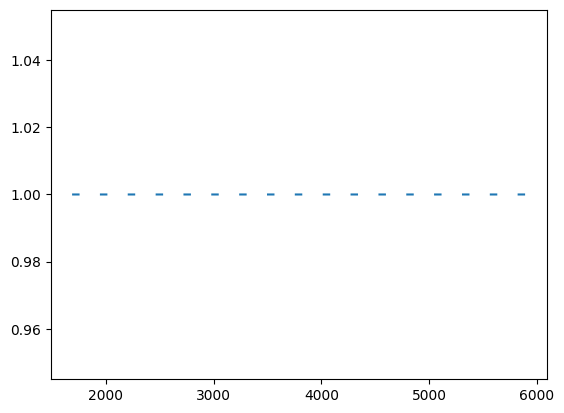

In [ ]:
plt.plot(data[1]['stim_ts']['delay'])

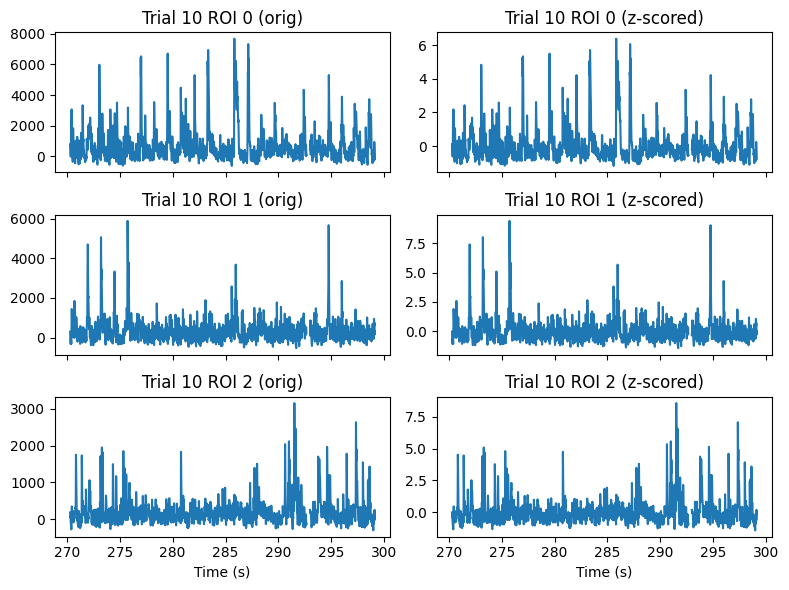

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# PICK OUT A TRIAL TO PLOT EXAMPLES LATER
example_trial_id = next(iter(data.keys()))
example = data[example_trial_id]

# 1) compute z-scored DMD1 for each trial up front
normalized = {}
for trial_id, trial_data in data.items():
    dmd = np.asarray(trial_data['DMD1'])    # shape (R, T)
    # mask out any timepoints (columns) with a NaN in any ROI
    valid      = ~np.isnan(dmd).any(axis=0)  # length T boolean
    clean      = dmd[:, valid]              # shape (R, Tc)
    mu         = np.nanmean(clean, axis=1)  # shape (R,)
    sigma      = np.nanstd(clean, axis=1)   # shape (R,)
    # broadcast back to (R, T), leaving NaNs where they were
    dmd_z      = (dmd - mu[:, None]) / sigma[:, None]
    normalized[trial_id] = dmd_z

# 4) PLOT EXAMPLES: first 3 ROIs of example trial, raw vs z-scored
fig, axs = plt.subplots(3, 2, figsize=(8, 6), sharex=True)
t_ex = np.asarray(example['time'])        # length T
d_ex = np.asarray(example['DMD1'])        # shape (R, T)
z_ex = normalized[example_trial_id]       # shape (R, T)

for i, roi in enumerate(range(3)):
    axs[i, 0].plot(t_ex, d_ex[roi, :])
    axs[i, 0].set_title(f'Trial {example_trial_id} ROI {roi} (orig)')
    axs[i, 1].plot(t_ex, z_ex[roi, :])
    axs[i, 1].set_title(f'Trial {example_trial_id} ROI {roi} (z-scored)')
    if i == 2:
        axs[i, 0].set_xlabel('Time (s)')
        axs[i, 1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

In [98]:
# Precompute z-scored DMD1 for all trials
normalized_dmd = {}

for trial_id, trial_data in data.items():
    dmd = np.asarray(trial_data['DMD1'])  # shape (R, T)
    # mask columns (timepoints) with NaNs in any ROI
    valid_timepoints = ~np.isnan(dmd).any(axis=0)  # shape (T,)
    dmd_valid = dmd[:, valid_timepoints]           # (R, T_valid)

    # z-score each ROI across valid timepoints
    mu = np.mean(dmd_valid, axis=1, keepdims=True)      # (R, 1)
    sigma = np.std(dmd_valid, axis=1, keepdims=True)    # (R, 1)
    dmd_z = (dmd - mu) / sigma                          # (R, T), NaNs retained
    normalized_dmd[trial_id] = dmd_z

When do they fire?

In [190]:
import numpy as np
import matplotlib.pyplot as plt

# PSTH params
t_start, t_end = -0.5, 0.5 # window
bin_width = 0.01 # 10ms
bins = np.arange(t_start, t_end + bin_width, bin_width)

# figure out how many ROIs you have from first trial
first_trial = next(iter(data.values()))
n_rois = np.array(first_trial['DMD1']).shape[0]

# list per roi to collect aligned spikes
all_aligned_spikes = [[] for _ in range(n_rois)]
n_stimuli = 0
spike_threshold = 2.5

for trial_id, trial_data in data.items():
    t = np.asarray(trial_data['time']) # (T,)
    dmd = normalized_dmd[trial_id]

    # clean up stim-onset times
    onsets = np.array(trial_data['stim_ts']['delay'])
    onsets = onsets[~np.isnan(onsets)] # drop NaNs

    # for each roi, filter out nans in time or dmd, then grab spike times
    for i in range(n_rois):
        # mask timepoints where t or dmd[i,:] is NaN
        valid = ~np.isnan(t) & ~np.isnan(dmd[i,:])
        t_clean = t[valid]
        dmd_clean = dmd[i,valid]

        spike_times=t_clean[dmd_clean > spike_threshold]

        # align each spike to stimulus onset
        for onset in onsets:
            aligned = spike_times - onset
            mask = (aligned >= t_start) & (aligned <= t_end)
            all_aligned_spikes[i].append(aligned[mask])

    n_stimuli += len(onsets)

# initialize PSTH array (time bins × ROIs)
psth = np.zeros((len(bins) - 1, n_rois))

# bin aligned spikes for each ROI
for i in range(n_rois):
    if all_aligned_spikes[i]:  # make sure there's data
        aligned_spikes = np.concatenate(all_aligned_spikes[i])
        counts, _ = np.histogram(aligned_spikes, bins=bins)
        psth[:, i] = counts / (n_stimuli * bin_width)  # spikes/sec

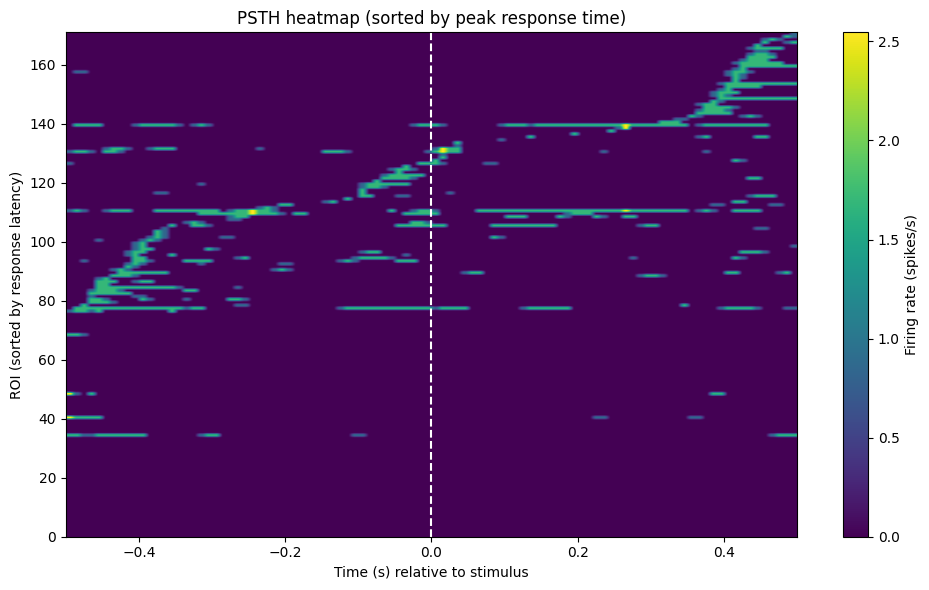

In [191]:
# Find the peak response time index for each ROI
peak_times = np.argmax(psth, axis=0)  # shape: (n_rois,)

# Sort ROIs by the time index of their peak response
sorted_indices = np.argsort(peak_times)

# Reorder the PSTH accordingly
psth_sorted = psth[:, sorted_indices]

# Heatmap across all ROIs
plt.figure(figsize=(10, 6))
plt.imshow(psth_sorted.T, aspect='auto', origin='lower',
           extent=[t_start, t_end, 0, n_rois])
plt.colorbar(label='Firing rate (spikes/s)')
plt.axvline(0, color='white', linestyle='--')
plt.xlabel('Time (s) relative to stimulus')
plt.ylabel('ROI (sorted by response latency)')
plt.title('PSTH heatmap (sorted by peak response time)')
plt.tight_layout()
plt.show()

PSTH by condition

In [192]:
# Find all unique orientations in the dataset
all_oris = []
for trial_data in data.values():
    oris = np.asarray(trial_data['stim_ts']['orientation'])
    all_oris.extend(oris[~np.isnan(oris)])

unique_oris = np.sort(np.unique(all_oris))
print("Unique orientations:", unique_oris)

from collections import defaultdict

all_aligned_spikes = [
    defaultdict(list) for _ in range(n_rois)
]
orientation_counts = defaultdict(int) # orientation --> number of presentations

Unique orientations: [0.         0.39269909 0.78539819 1.17809725 1.57079637 1.96349537
 2.3561945  2.7488935  3.14159274 3.53429174 3.92699075 4.49422264
 4.71238899 5.10508823 5.497787   5.89048624]


In [193]:
spike_threshold = 2.5

for trial_id, trial_data in data.items():
    t = np.asarray(trial_data['time'])
    dmd = normalized_dmd[trial_id]
    onsets = np.asarray(trial_data['stim_ts']['delay'])
    oris = np.asarray(trial_data['stim_ts']['orientation'])

    valid_mask = ~np.isnan(onsets) & ~np.isnan(oris)
    onsets = onsets[valid_mask]
    oris = oris[valid_mask]

    for i in range(n_rois):
        valid = ~np.isnan(t) & ~np.isnan(dmd[i,:])
        t_clean = t[valid]
        dmd_clean = dmd[i, valid]
        spike_times = t_clean[dmd_clean > spike_threshold]

        for onset, ori in zip(onsets, oris):
            aligned = spike_times - onset
            mask = (aligned >= t_start) & (aligned <= t_end)
            all_aligned_spikes[i][ori].append(aligned[mask])
            orientation_counts[ori] += 1

# PSTH[orientation] = [n_bins × n_rois]
psth_by_ori = {}

for ori in unique_oris:
    psth = np.zeros((len(bins) - 1, n_rois))
    for i in range(n_rois):
        if ori in all_aligned_spikes[i]:
            aligned = np.concatenate(all_aligned_spikes[i][ori])
            counts, _ = np.histogram(aligned, bins=bins)
            psth[:, i] = counts / (orientation_counts[ori] * bin_width)
    psth_by_ori[ori] = psth

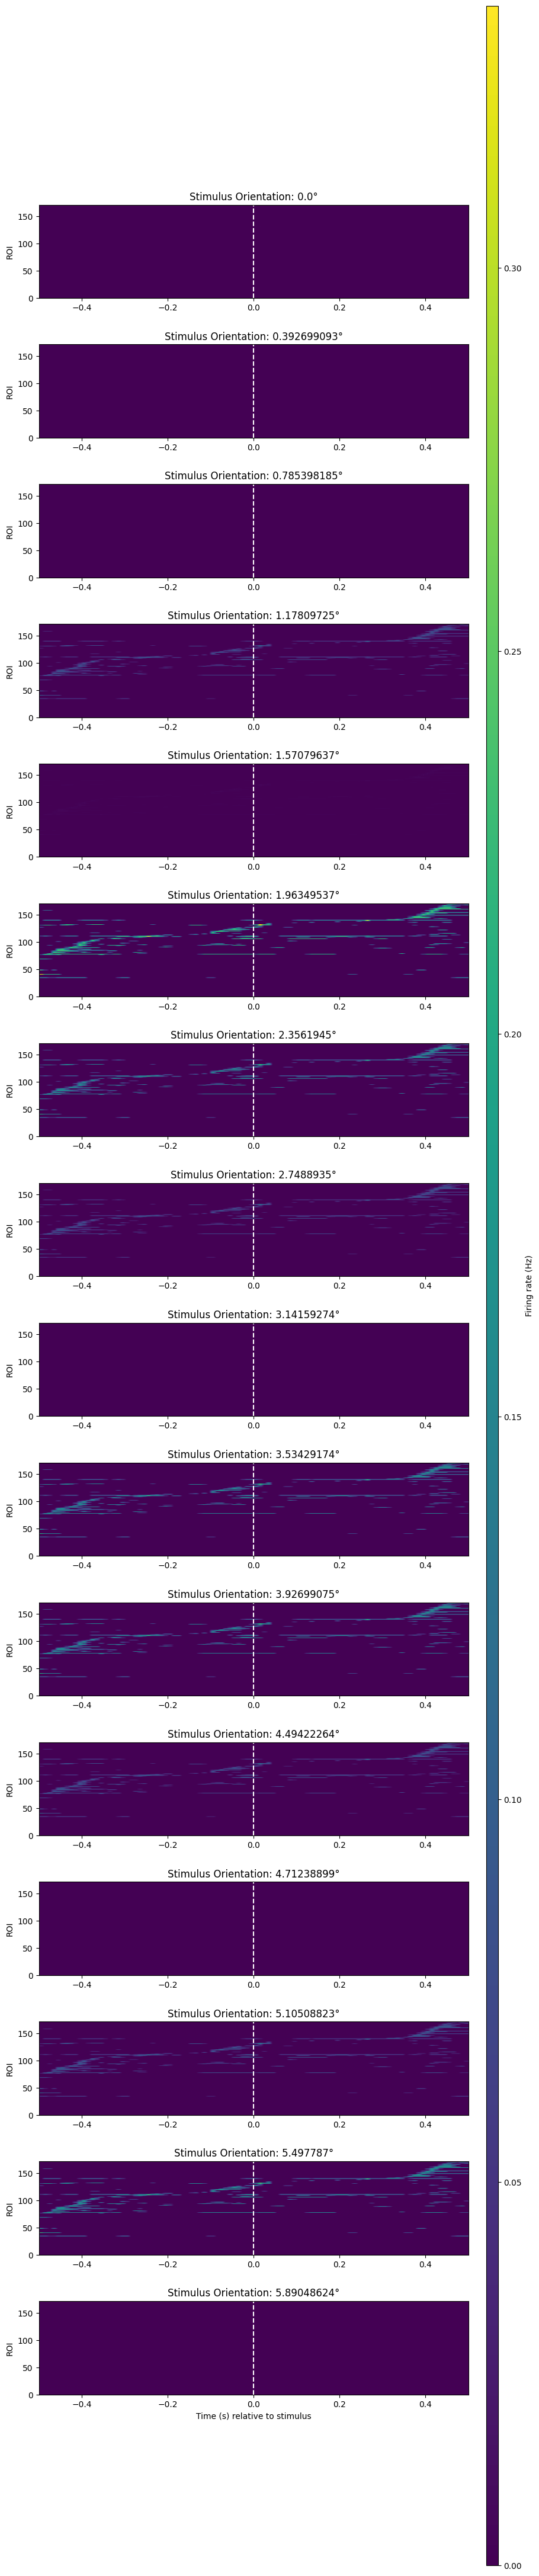

In [194]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Configuration
sort_by_latency = True
n_oris = len(unique_oris)
fig_height_per_ori = 3  # inches per orientation
fig_width = 10

fig = plt.figure(figsize=(fig_width, fig_height_per_ori * n_oris))
gs = gridspec.GridSpec(n_oris, 1, hspace=0.5)

vmin = min(psth_by_ori[ori].min() for ori in unique_oris)
vmax = max(psth_by_ori[ori].max() for ori in unique_oris)

for i, ori in enumerate(unique_oris):
    ax = fig.add_subplot(gs[i])
    psth = psth_by_ori[ori]

    if sort_by_latency:
        peak_times = np.argmax(psth, axis=0)
        sorted_idx = np.argsort(peak_times)
        psth = psth[:, sorted_idx]

    im = ax.imshow(
        psth.T, aspect='auto', origin='lower',
        extent=[t_start, t_end, 0, n_rois],
        vmin=vmin, vmax=vmax, cmap='viridis'
    )
    ax.axvline(0, color='white', linestyle='--')
    ax.set_title(f'Stimulus Orientation: {ori}°')
    ax.set_ylabel('ROI')

ax.set_xlabel('Time (s) relative to stimulus')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.05, 0.02, 0.9])
fig.colorbar(im, cax=cbar_ax, label='Firing rate (Hz)')

plt.show()

In [197]:
# response_strengths[roi, ori_idx] = average response
ori_values = list(unique_oris)
ori_to_idx = {ori: i for i, ori in enumerate(ori_values)}
response_strengths = np.zeros((n_rois, len(ori_values)))

for ori in ori_values:
    psth = psth_by_ori[ori] # shape: (n_bins, n_rois)
    # peak response
    #mean_response = np.max(psth,axis=0)
    # mean over time
    mean_response = np.mean(psth,axis=0)

    idx = ori_to_idx[ori]
    response_strengths[:,idx] = mean_response

# index of preferred orientation per ROI
preferred_ori_idx = np.argmax(response_strengths, axis=1)
preferred_oris = [ori_values[i] for i in preferred_ori_idx]

C:\Users\nicho\AppData\Local\Temp\ipykernel_24204\995220980.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='viridis')


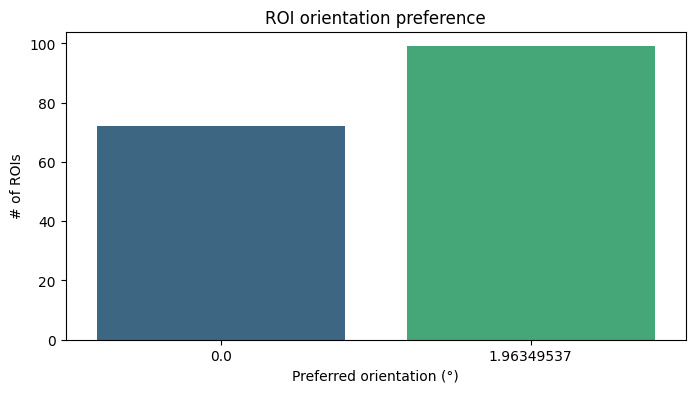

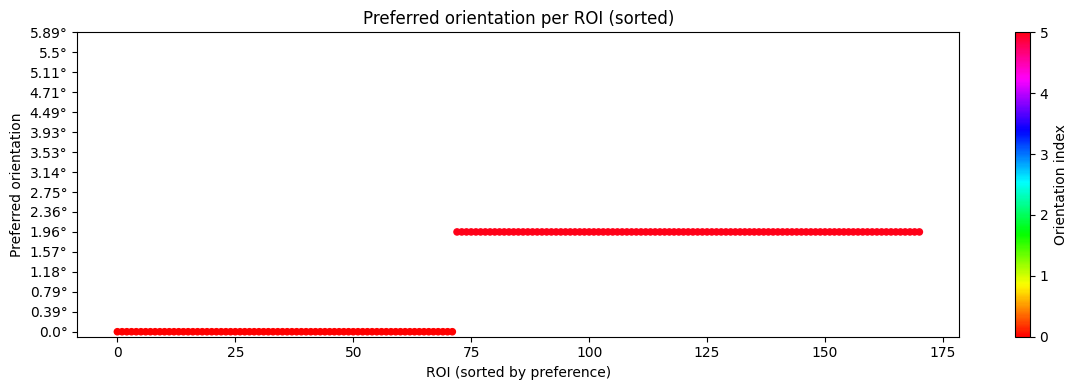

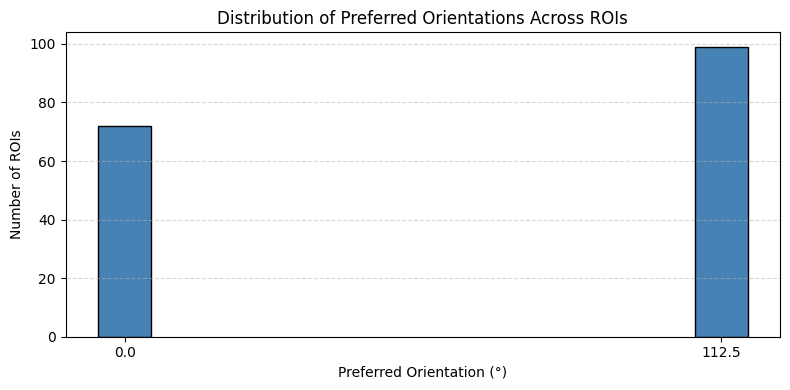

In [198]:
from collections import Counter
import seaborn as sns

plt.figure(figsize=(8, 4))
counts = Counter(preferred_oris)
sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='viridis')
plt.xlabel('Preferred orientation (°)')
plt.ylabel('# of ROIs')
plt.title('ROI orientation preference')
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Step 1: Sort ROIs by preferred orientation index
sorted_idx = np.argsort(preferred_ori_idx)
sorted_oris = np.array(preferred_ori_idx)[sorted_idx]

# Step 2: Plot
plt.figure(figsize=(12, 4))
sc = plt.scatter(np.arange(n_rois), sorted_oris, c=sorted_oris, cmap='hsv', s=20)

plt.yticks(ticks=range(len(ori_values)), labels=[f"{round(o, 2)}°" if o <= 180 else f"{round(np.rad2deg(o)%180, 2)}°" for o in ori_values])
plt.xlabel('ROI (sorted by preference)')
plt.ylabel('Preferred orientation')
plt.title('Preferred orientation per ROI (sorted)')
cbar = plt.colorbar(sc)
cbar.set_label('Orientation index')
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt

# Convert to degrees if values are in radians
preferred_oris_deg = np.rad2deg(preferred_oris)

# Count how many ROIs prefer each orientation
unique_degrees = np.unique(preferred_oris_deg)
counts = [np.sum(preferred_oris_deg == deg) for deg in unique_degrees]

# Plot
plt.figure(figsize=(8, 4))
bars = plt.bar(unique_degrees, counts, width=10, color='steelblue', edgecolor='black')

plt.xlabel('Preferred Orientation (°)')
plt.ylabel('Number of ROIs')
plt.title('Distribution of Preferred Orientations Across ROIs')
plt.xticks(unique_degrees)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()